In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import viridis

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees
from src.agents.agent import TransformerAgent
from src.envs.trees import TreeEnvVec


# Load Model

In [3]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "cntree"
corr = 0.25
env_name = f"cntree_layers7_bprob0.9_corr{corr}_state_dim10_envs300000_H800_explore"
model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.2_batch256"
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
print(ckpt_name)
path_to_pkl = os.path.join(model_path, ckpt_name)

eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/cntree/cntree_layers7_bprob1.0_corr{corr}_state_dim10_envs1000_H1600_explore/datasets/eval.pkl"

epoch=31-val_loss=0.000672.ckpt


In [5]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
corr = float(re.search(r'corr(\d*\.?\d*)', eval_dset_path).group(1))
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

In [6]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_3276603/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [7]:
n_eval_envs = 50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()

In [8]:
eval_func = EvalCntrees()

In [9]:
i_eval = 4
traj = eval_trajs[i_eval]
env_config = {
    'max_layers': 7,
    'horizon': 1600,
    'branching_prob': 1.0,
    'node_encoding_corr': corr,
    'state_dim': state_dim,
    'initialization_seed': np.array(traj['initialization_seed']).item()
}
env = eval_func.create_env(env_config, np.array(traj['goal']), i_eval)
print(traj['context_rewards'][:1000].sum())


30


# Count action distribution

In [10]:
def offline_act_bias(traj, model, env, with_reward=False):
    """ Runs each episode separately with offline context. """

    seen_states = np.vstack((traj['context_states'][:1], traj['context_next_states']))
    seen_states = np.unique(seen_states, axis=0)
    actions = []

    for state in seen_states: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            batch[k] = batch[k].to(model.device)
        if not with_reward:
            batch['context_rewards'] *= 0
        with torch.no_grad():
            out = model(batch)
            actions.append(torch.argmax(out).item())
    formatted_states = [env.node_map[tuple(s.tolist())] for s in seen_states]
    formatted_states = [(s.layer, s.pos) for s in formatted_states]
    return formatted_states, actions

In [ ]:
context_length = 1000

In [19]:
is_root = []
actions = []
for i_eval in range(5):
    traj = eval_trajs[i_eval]
    env_config = {
        'max_layers': 7,
        'horizon': 1600,
        'branching_prob': 1.0,
        'node_encoding_corr': corr,
        'state_dim': state_dim,
        'initialization_seed': np.array(traj['initialization_seed']).item()
    }
    env = eval_func.create_env(env_config, np.array(traj['goal']), i_eval)

    _traj = {}
    for k in traj.keys():
        if 'context' in k:
            val = traj[k][:context_length]
        else:
            val = traj[k]
        _traj[k] = val

    states, acts = offline_act_bias(traj, model, env)
    is_root.extend([s==(0,0) for s in states])
    actions.extend(acts)

In [20]:
import seaborn as sns

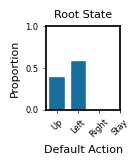

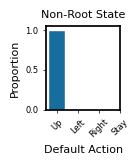

In [38]:
# ...existing code...
df = pd.DataFrame({
    'is_root': is_root,
    'action': actions
})

# Count occurrences
count_df = df.groupby(['is_root', 'action']).size().reset_index(name='count')

# Normalize within each is_root group
count_df['proportion'] = count_df.groupby('is_root')['count'].transform(lambda x: x / x.sum())

plt.figure(figsize=(1.5, 1.75))
sns.barplot(
    data=count_df[count_df['is_root'] == True],
    x='action', y='proportion')
plt.xlabel('Default Action', fontsize=8)
plt.ylabel('Proportion', fontsize=8)
plt.title('Root State', fontsize=8)
plt.xticks(
    np.arange(4), ['Up', 'Left', 'Right', 'Stay'],
    rotation=45, fontsize=6)
plt.yticks([0, 0.5, 1.0], fontsize=6)
plt.tight_layout()
plt.savefig('figs_app/N_22A.png', transparent=True, dpi=300)
plt.savefig('figs_app/N_22A.pdf', transparent=True, dpi=300)
plt.show()

plt.figure(figsize=(1.5, 1.75))
sns.barplot(
    data=count_df[count_df['is_root'] == False],
    x='action', y='proportion')
plt.xlabel('Default Action', fontsize=8)
plt.ylabel('Proportion', fontsize=8)
plt.title('Non-Root State', fontsize=8)
plt.xticks(
    np.arange(4), ['Up', 'Left', 'Right', 'Stay'],
    rotation=45, fontsize=6)
plt.yticks([0, 0.5, 1.0], fontsize=6)
plt.tight_layout()
plt.savefig('figs_app/N_22B.png', transparent=True, dpi=300)
plt.savefig('figs_app/N_22B.pdf', transparent=True, dpi=300)
plt.show()